# WaveRNN - Fit a 30min Sample

In [1]:
!apt-get install -y libsndfile-dev




Note, selecting 'libsndfile1-dev' instead of 'libsndfile-dev'
The following additional packages will be installed:
  libflac-dev libflac8 libogg-dev libogg0 libsndfile1 libvorbis-dev
  libvorbis0a libvorbisenc2 libvorbisfile3
The following NEW packages will be installed:
  libflac-dev libflac8 libogg-dev libogg0 libsndfile1 libsndfile1-dev
  libvorbis-dev libvorbis0a libvorbisenc2 libvorbisfile3
0 upgraded, 10 newly installed, 0 to remove and 21 not upgraded.
Need to get 1597 kB of archives.
After this operation, 6532 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libogg-dev amd64 1.3.2-1 [156 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libflac-dev amd64 1.3.2-1 [260 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbis0a a

In [2]:
import time, sys, math
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, notebook
from scipy.io import wavfile
from librosa import resample
import time

In [3]:
from dsp_py import *
from display_py import *
from wavernn_extended_biased_py import WaveRNN

In [4]:
files = [('../input/sounds/prova_glass.wav', 'glass'), ('../input/sounds/prova_glass.wav', 'silicon')]
# files = [('../data/prova_silicon.wav', 'silicon')]

In [5]:
notebook_name = 'biased_v1'
sample_rate = 22050
#epochs = 2
batch_size = 128

model = WaveRNN(num_sounds = len(files)).cuda()

Trainable Parameters: 3.055 million


In [6]:
def split_signal(x) :
    unsigned = x + 2**15
    coarse = unsigned // 256
    fine = unsigned % 256
    return coarse, fine

In [7]:
def combine_signal(coarse, fine) :
    return coarse * 256 + fine - 2**15

In [8]:
def read_signal(file):
    sr, sample = wavfile.read(file)
    sample = sample.sum(axis=1) / 2
    sample = resample(sample, orig_sr = sr, target_sr = sample_rate)
    sample = sample.astype(np.int16)
    return sample

In [9]:
def preprocess_signal(signal, batch_size=batch_size):
    coarse_classes, fine_classes = split_signal(signal)
    coarse_classes = coarse_classes[:len(coarse_classes) // batch_size * batch_size]
    fine_classes = fine_classes[:len(fine_classes) // batch_size * batch_size]
    coarse_classes = np.reshape(coarse_classes, (batch_size, -1))
    fine_classes = np.reshape(fine_classes, (batch_size, -1))
    return coarse_classes, fine_classes

In [10]:
asmr2idx = dict()
idx2asmr = []
def asmr_processor(asmr_type):
    if asmr_type not in asmr2idx:
        idx2asmr.append(asmr_type)
        asmr2idx[asmr_type] = len(idx2asmr) - 1
    return asmr2idx[asmr_type]

### Split/Combine Functions

In [11]:
def train(model, optimizer, asmr_number, num_steps, batch_size, lr=1e-3, seq_len=960) :
    
    for p in optimizer.param_groups : p['lr'] = lr
    start = time.time()
    running_loss = 0
    
    for step in range(num_steps) :

        loss = 0
        hidden = model.init_hidden(batch_size)
        #sound_idx_embed = model.init_embedding(batch_size) * asmr_number
        sound_idx_embed = torch.ones(1, dtype=torch.long).cuda() * asmr_number
        optimizer.zero_grad()
        rand_idx = np.random.randint(0, coarse_classes.shape[1] - seq_len - 1)
        
        x_coarse = coarse_classes[:, rand_idx:rand_idx + seq_len]
        x_coarse = torch.FloatTensor(x_coarse)
        x_coarse = x_coarse / 127.5 - 1.
        x_fine = fine_classes[:, rand_idx:rand_idx + seq_len]
        x_fine = torch.FloatTensor(x_fine)
        x_fine = x_fine / 127.5 - 1.
        
        y_coarse = coarse_classes[:, rand_idx + 1:rand_idx + seq_len + 1]
        y_coarse = torch.LongTensor(y_coarse)
        y_fine = fine_classes[:, rand_idx + 1: rand_idx + seq_len + 1]
        y_fine = torch.LongTensor(y_fine)

        for i in range(seq_len) :
            
            x_c_in = x_coarse[:, i:i + 1]
            x_f_in = x_fine[:, i:i + 1]
            x_input = torch.cat([x_c_in, x_f_in], dim=1)
            x_input = x_input.cuda()
            
            c_target = y_coarse[:, i].cuda()
            f_target = y_fine[:, i].cuda()
            
            
            current_coarse = c_target.float() / 127.5 - 1.
            current_coarse = current_coarse.unsqueeze(-1)
            
            out_coarse, out_fine, hidden = model(sound_idx_embed, x_input, hidden, current_coarse)
            
            loss_coarse = F.cross_entropy(out_coarse, c_target)
            loss_fine = F.cross_entropy(out_fine, f_target)
            loss += (loss_coarse + loss_fine)
        
        running_loss += (loss.item() / seq_len)
        loss.backward()
        optimizer.step()
        
        losses.append(running_loss / (len(losses)+0.001))
        
        elapsed = time_since(start)
        speed = (step + 1) / (time.time() - start)
        
        stream('Step: %i/%i --- Loss: %.3f --- %s --- @ %.1f batches/sec ',
              (step + 1, num_steps, running_loss / (step + 1), elapsed, speed))         

In [12]:
optimizer = optim.Adam(model.parameters())

In [13]:
from random import choice

In [14]:
sounds = [(preprocess_signal(read_signal(file)), asmr_processor(asmr_type)) for file, asmr_type in files]
losses = []
init = time.time()
cont = 0
while time.time() - init < 3600*7.75:
    for (sample, asmr_number) in sounds:
        coarse_classes, fine_classes = sample
        
        #asmr_number = torch.ones([batch_size], dtype=torch.long).cuda() * asmr_number
        
        num_epochs = 3 #choice([3])
        cont += num_epochs
        train(model, optimizer, asmr_number, num_steps=num_epochs, batch_size=batch_size, lr=1e-3)
    
print(cont)

Step: 3/3 --- Loss: 1.904 --- 0m 7s --- @ 0.4 batches/sec 10974


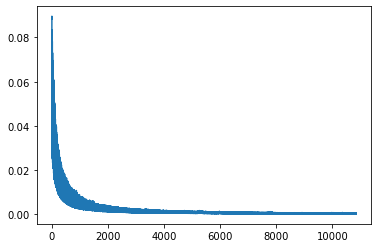

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses[125:])

In [16]:
losses

[11284.600830078125,
 20.83566457956107,
 14.449213076567187,
 3.461779084163786,
 4.774718287387788,
 5.1174043552292146,
 0.849796992927394,
 1.4118399636175487,
 1.8077275506984154,
 0.4958827297003169,
 0.8812478330617458,
 1.1953415315996367,
 0.3580565995992305,
 0.661814247336543,
 0.9196236363859984,
 0.2757097518097318,
 0.5179161623443456,
 0.7265981621801427,
 0.22604836558107158,
 0.4281579056403144,
 0.6121256004867399,
 0.2183430195195318,
 0.395082849109812,
 0.5506178801428357,
 0.1887946195533411,
 0.34604005244087105,
 0.48526363730539107,
 0.1496908813429846,
 0.28948247735688193,
 0.41958423594902977,
 0.15644745571197974,
 0.2891951763054266,
 0.40304691120034586,
 0.13107463639043768,
 0.2550554393783532,
 0.362831248615646,
 0.11218054657082732,
 0.2174738625052293,
 0.3115035349411549,
 0.10542044660738868,
 0.20058887006421847,
 0.2953626157369034,
 0.0946127268934693,
 0.18147910300043593,
 0.2672807000450511,
 0.08591979499884088,
 0.16926304046322818,
 0.246

In [17]:
torch.save(model.state_dict(), f'model_{notebook_name}.pt')

In [18]:
#model.load_state_dict(torch.load(f'../input/models/model_{notebook_name}.pt'))

In [19]:
num_samples = 20500 * 10
output, c, f = model.generate(num_samples, [0])

Gen: 205000/205000 -- Speed: 585

In [20]:
def save_wav(y, filename, sample_rate) :
    y = np.clip(y, -2**15, 2**15 - 1)
    wavfile.write(filename, sample_rate, y.astype(np.int16))

In [21]:
versio = 1
material = "glass"
output_path = f'gen_{notebook_name}_{material}_{versio}.wav'
save_wav(output, output_path, sample_rate)

In [22]:
output, c, f = model.generate(num_samples, [1])
versio = 1
material = "silicon"
output_path = f'gen_{notebook_name}_{material}_{versio}.wav'
save_wav(output, output_path, sample_rate)

Gen: 205000/205000 -- Speed: 597

In [23]:
output, c, f = model.generate(num_samples, [0, 1])
versio = 1
material = "silicass"
output_path = f'gen_{notebook_name}_{material}_{versio}.wav'
save_wav(output, output_path, sample_rate)

Gen: 205000/205000 -- Speed: 598